In [97]:
from __future__ import division
import os
import sys

from glob import glob

import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [44]:
np.set_printoptions(threshold=np.nan)

In [57]:
def read_ms_file(fp):
    with open(fp) as fh:
        ## Skip first two lines
        fh.readline()
        fh.readline()

        ## Parse positions
        positions = map(float, fh.readline().replace('positions: ','').split())

        ## Make genotype array
        seqs = [map(int, j) for j in map(list, [x.strip() for x in fh])]
        gt = np.array(seqs)
        
        return positions,gt

In [80]:
def get_trajectories(baseDir):
    posANC,gtANC = read_ms_file(os.path.join(baseDir,'ms_ANC.txt'))
    posOOA,gtOOA = read_ms_file(os.path.join(baseDir,'ms_OOA.txt'))
    posAFR,gtAFR = read_ms_file(os.path.join(baseDir,'ms_AFR.txt'))
    posEUR,gtEUR = read_ms_file(os.path.join(baseDir,'ms_EUR.txt'))
    posEAS,gtEAS = read_ms_file(os.path.join(baseDir,'ms_EAS.txt'))
    
    ## Determine which positions are shared from beginning
    shared = set.intersection(set(posANC),set(posOOA),set(posAFR),set(posEUR),set(posEAS))
    
    ## Get AF trajectory for each SNP
    trajectories = []
    for pos in sorted(list(shared)):
        afANC = gtANC[:,posANC.index(pos)].mean()
        afOOA = gtOOA[:,posOOA.index(pos)].mean()
        afAFR = gtAFR[:,posAFR.index(pos)].mean()
        afEUR = gtEUR[:,posEUR.index(pos)].mean()
        afEAS = gtEAS[:,posEAS.index(pos)].mean()
        afGAF = (afEUR+afEAS+afAFR)*(1/3)

        trajectories.append((afANC,afOOA,afAFR,afEUR,afEAS,afGAF))
    
    return trajectories

In [82]:
trajectories = []
for replicate in glob('/DATA/raw/sims/results/*'):
    res = get_trajectories(replicate)
    trajectories.extend(res)

In [84]:
traj = pd.DataFrame(trajectories, columns=['af_ANC','af_OOA','af_AFR','af_EUR','af_EAS', 'GAF'])

In [86]:
traj['anc_cap'] = traj.apply(lambda x:True if x['af_ANC']>=0.05 else False, axis=1)

In [88]:
traj['ooa_cap'] = traj.apply(lambda x:True if x['af_OOA']>=0.05 else False, axis=1)

In [89]:
traj['global_cap'] = traj.apply(lambda x:True if x['GAF']>=0.05 else False, axis=1)

In [90]:
traj.head()

,af_ANC,af_OOA,af_AFR,af_EUR,af_EAS,GAF,anc_cap,ooa_cap,global_cap
0,0.11,0.22,0.15,0.55,0.38,0.360000,True,True,True
1,0.18,0.22,0.21,0.55,0.38,0.380000,True,True,True
2,0.42,0.51,0.39,0.60,0.43,0.473333,True,True,True
3,0.24,0.29,0.18,0.05,0.05,0.093333,True,True,True
4,0.18,0.22,0.21,0.55,0.38,0.380000,True,True,True


In [95]:
traj['anc_cap'].sum()

13553

In [96]:
traj['global_cap'].sum()

14694

In [94]:
traj.shape

(14940, 9)

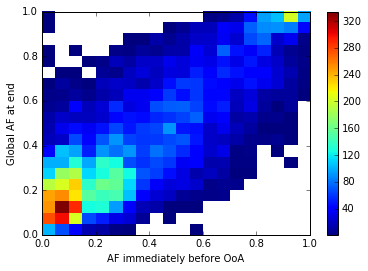

In [104]:
plt.hist2d(traj['af_ANC'],traj['GAF'], bins=np.linspace(0,1,21), cmin=1)
plt.colorbar()

ax = plt.gca()

ax.set_xlabel('AF immediately before OoA')
ax.set_ylabel('Global AF at end')